In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


%matplotlib inline

In [2]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10380856461084774237
xla_global_id: -1
]


In [3]:
test_dir = 'FastFood/Test/'
val_dir = 'FastFood/Valid/'
train_dir = 'FastFood/Train/'

In [4]:
# Collecte the class names.
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 10
Classes     : ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


In [5]:
def make_cnn_model(learning_rate=0.03, size_inner=100, droprate=0.5):    
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    model = models.Sequential()
    model.add(keras.Input(shape=(150, 150, 3)))
    model.add(base_model)

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(size_inner, activation='relu'))
    model.add(layers.Dropout(droprate))
    model.add(layers.Dense(n_classes, activation='softmax', kernel_initializer='zeros'))
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    metricsClass = [
        metrics.AUC(),
        metrics.CategoricalAccuracy(),
        metrics.Precision(),
        metrics.Recall()
    ]

    model.compile(loss=loss,\
                optimizer=optimizer,\
                metrics=metricsClass)
    
    return model

In [6]:
def create_generator(batch_size=126,**kwargs):
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_ds = train_gen.flow_from_directory(train_dir,  batch_size=batch_size, target_size=(128,128),**kwargs)
    
    valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_ds = valid_gen.flow_from_directory(val_dir,  batch_size=batch_size, target_size=(128,128))
    
    return train_ds,val_ds


In [7]:
def train(model,train_ds,val_ds,epochs=3,path='model'):
    checkpoint = keras.callbacks.ModelCheckpoint(
        path+'_{val_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='val_categorical_accuracy',
        initial_value_threshold=0.6,
        mode='max'
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[checkpoint]
    )
    return history

In [8]:
train_ds,val_ds = create_generator(256)

Found 6283 images belonging to 10 classes.
Found 3500 images belonging to 10 classes.


In [9]:
train_ds.class_indices


{'Baked Potato': 0,
 'Burger': 1,
 'Crispy Chicken': 2,
 'Donut': 3,
 'Fries': 4,
 'Hot Dog': 5,
 'Pizza': 6,
 'Sandwich': 7,
 'Taco': 8,
 'Taquito': 9}

In [10]:
scores = {}

for ind,size_inner in enumerate([50,100,150]):
    print(size_inner)
    epochs =6
    filename = f'xception_v1_size_{size_inner}' 

    model = make_cnn_model(learning_rate=0.003, size_inner=size_inner, droprate=0.0)
    history = train(model,train_ds,val_ds,epochs,filename)
    scores[size_inner] = history.history
    del model
    del history
    print()
    print()

50
Epoch 1/6
 5/25 [=====>........................] - ETA: 45s - loss: 2.2510 - auc: 0.6103 - categorical_accuracy: 0.1719 - precision: 0.0000e+00 - recall: 0.0000e+00

c:\Users\user\.virtualenvs\Capstone_1-1Zn1mtGM\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 91s 4s/step - loss: 1.6017 - auc: 0.8504 - categorical_accuracy: 0.4754 - precision: 0.8110 - recall: 0.1974 - val_loss: 1.2748 - val_auc: 0.9082 - val_categorical_accuracy: 0.5849 - val_precision: 0.7411 - val_recall: 0.4589
Epoch 2/6
25/25 [==============================] - 88s 4s/step - loss: 0.9761 - auc: 0.9446 - categorical_accuracy: 0.6734 - precision: 0.8225 - recall: 0.5464 - val_loss: 1.1299 - val_auc: 0.9258 - val_categorical_accuracy: 0.6454 - val_precision: 0.7933 - val_recall: 0.4989
Epoch 3/6
25/25 [==============================] - 88s 4s/step - loss: 0.8238 - auc: 0.9606 - categorical_accuracy: 0.7275 - precision: 0.8511 - recall: 0.6161 - val_loss: 1.0931 - val_auc: 0.9303 - val_categorical_accuracy: 0.6554 - val_precision: 0.7849 - val_recall: 0.5389
Epoch 4/6
25/25 [==============================] - 88s 4s/step - loss: 0.7287 - auc: 0.9690 - categorical_accuracy: 0.7622 - precision: 0.8640 - recall: 0.6613 - val_loss: 1.1028 

In [19]:
score_size_50 = scores[50]
score_size_100 = scores[100]
score_size_150 = scores[150]

In [23]:
scores =  [score_size_50,score_size_100,score_size_150]

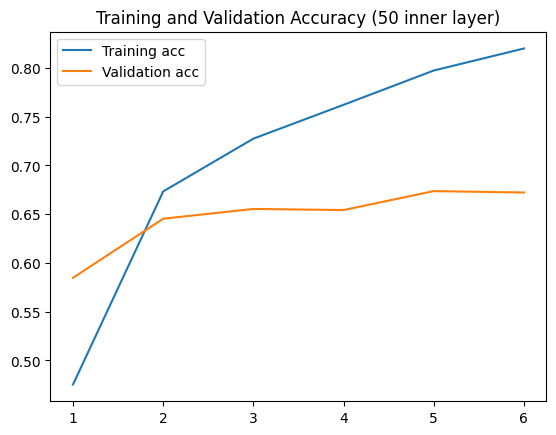

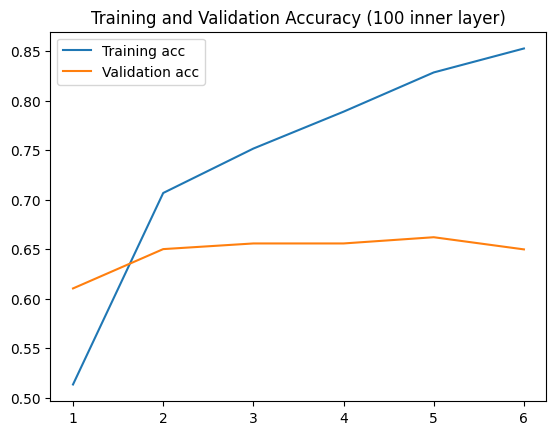

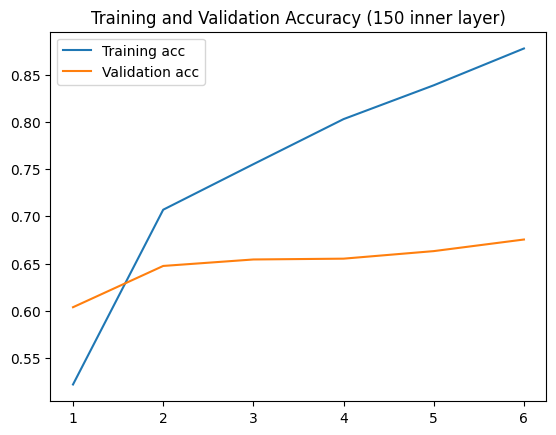

In [25]:
layer_s = [50,100,150]
for s,l in zip(scores,layer_s):
    acc = s['categorical_accuracy']
    val_acc= s['val_categorical_accuracy']
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')

    plt.title(f'Training and Validation Accuracy ({l} inner layer)')
    plt.legend()
    plt.show()

In [ ]:
scores = {}

for ind,size_inner in enumerate([50,100,150]):
    print(size_inner)
    epochs =6
    filename = f'xception_v1_size_{size_inner}' 

    model = make_cnn_model(learning_rate=0.003, size_inner=size_inner, droprate=0.0)
    history = train(model,train_ds,val_ds,epochs,filename)
    scores[size_inner] = history.history
    del model
    del history
    print()
    print()